##HYDROGEN AND LITHIUM HYBRID ENERGY STORAGE

Optimal system design found:

Financial Summary:
System lifetime: 15 years
Total capital investment: $303,116.23
Present value of O&M costs: $160,788.08
Total system cost (NPV): $463,904.31
Lifetime hydrogen production: 150,000.00 kg
Levelized hydrogen cost: $3.09/kg

System Capacities:
Wind farm capacity: 0.00 kW
Solar PV capacity: 634.23 kW
Battery storage capacity: 505.49 kW
Electrolyzer capacity: 123.41 kW
Levelized H2 cost (partial year): $254.71/kg
Electrolyzer utilization rate: 44.04%


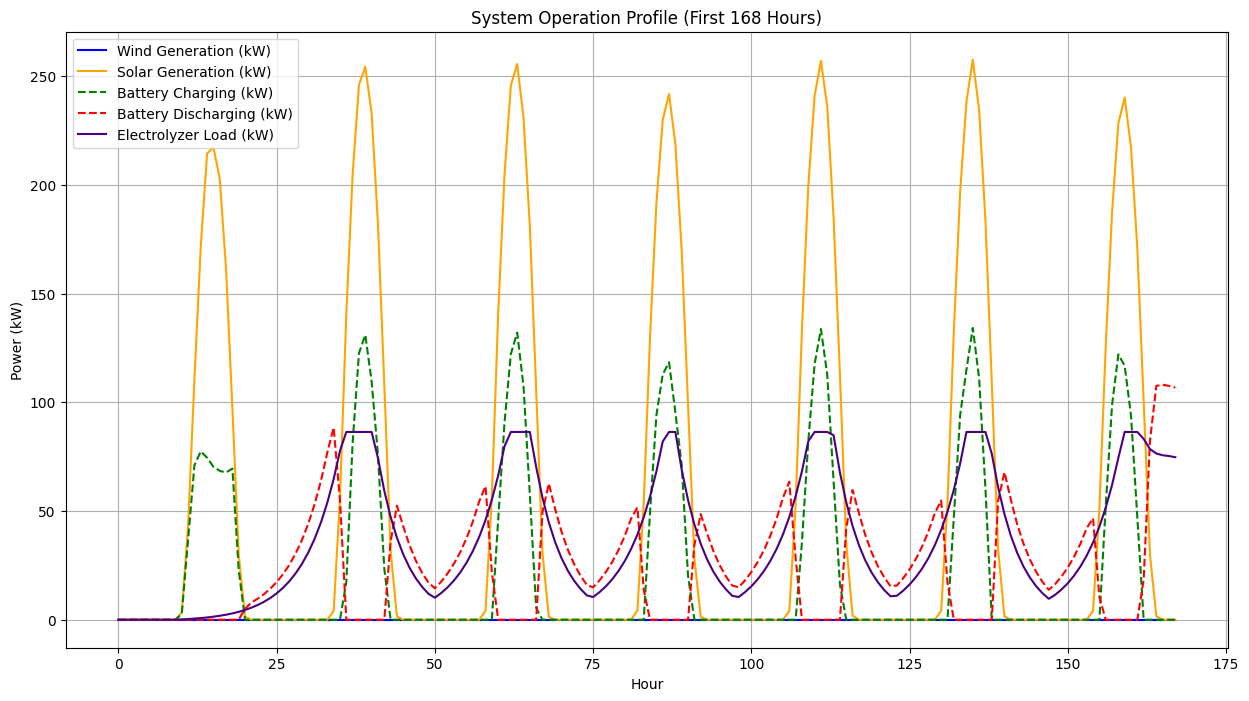

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
!pip install gurobipy
from gurobipy import Model, GRB

# Import renewable generation profiles for 8760 hours
renewable_profile = pd.read_csv('solar_&_wind_data.csv')
solar_generation = renewable_profile.iloc[:, 0].values  # Solar PV output column
wind_generation = renewable_profile.iloc[:, 1].values*0.8  # Wind output column with derating

# System component cost parameters ($/kW)
wind_install = 500  # Wind turbine capital cost
pv_install = 300    # Solar PV capital cost
storage_install = 150  # Battery storage capital cost
h2_plant_install = 300  # Electrolyzer capital cost

# System efficiencies
h2_plant_efficiency = 0.7  # Electrolyzer conversion efficiency
storage_rt_efficiency = 0.9  # Battery round-trip efficiency
storage_charge_cost = 0.001  # Minor cost for battery charging ($/kWh)
storage_discharge_cost = 0.001  # Minor cost for battery discharging ($/kWh)

# Annual maintenance costs ($/kW/year)
wind_maintenance = 20
pv_maintenance = 15
storage_maintenance = 10
h2_plant_maintenance = 25

# Financial parameters
annual_discount = 0.07  # Discount rate for NPV calculations
wind_life = 20  # Operational lifespan (years)
pv_life = 25
storage_life = 10
h2_plant_life = 15

h2_target = 10 * 1000  # Annual hydrogen production target (kg)
excess_penalty = 0  # Cost for unused renewable generation ($/kWh)

Flexibility = 0.2 # Maximum hourly output variation for electrolyzer

# Initialize optimization model
opt_model = Model("H2_Production_System_Design")
opt_model.setParam('OutputFlag', 0)

# Set solver parameters for large-scale problem
opt_model.setParam('TimeLimit', 100)  # Runtime limit in seconds
opt_model.setParam('MIPFocus', 1)  # Priority on feasibility
opt_model.setParam('Threads', 1)  # Limit computational threads
opt_model.setParam('MIPGap', 0.1)

# Decision variables for system capacities
wind_size = opt_model.addVar(lb=0, name="wind_cap")
pv_size = opt_model.addVar(lb=0, name="pv_cap")
storage_size = opt_model.addVar(lb=0, name="battery_cap")
h2_plant_size = opt_model.addVar(lb=0, name="electrolyzer_cap")

# Reduced simulation period for computational efficiency
sim_hours = 24 * 7  # One week simulation (168 hours)

# Operational variables
storage_energy = opt_model.addVars(sim_hours, lb=0, name="battery_energy")
charge_power = opt_model.addVars(sim_hours, lb=0, name="charge")
discharge_power = opt_model.addVars(sim_hours, lb=0, name="discharge")
h2_plant_load = opt_model.addVars(sim_hours, lb=0, name="electrolyzer_load")
excess_power = opt_model.addVars(sim_hours, lb=0, name="excess_gen")

# Annualized cost calculations
wind_annualized = wind_install * annual_discount / (1 - (1 + annual_discount) ** -wind_life) + wind_maintenance
pv_annualized = pv_install * annual_discount / (1 - (1 + annual_discount) ** -pv_life) + pv_maintenance
storage_annualized = storage_install * annual_discount / (1 - (1 + annual_discount) ** -storage_life) + storage_maintenance
h2_plant_annualized = h2_plant_install * annual_discount / (1 - (1 + annual_discount) ** -h2_plant_life) + h2_plant_maintenance

# Objective function: Minimize total system cost
opt_model.setObjective(
    (wind_annualized * wind_size + pv_annualized * pv_size + storage_annualized * storage_size + h2_plant_annualized * h2_plant_size)
    + excess_penalty * sum(excess_power[t] for t in range(sim_hours)) / sim_hours
    + storage_charge_cost * sum(charge_power[t] for t in range(sim_hours))
    + storage_discharge_cost * sum(discharge_power[t] for t in range(sim_hours)),
    GRB.MINIMIZE
)

# System constraints
for t in range(1, sim_hours):
    opt_model.addConstr(h2_plant_load[t]+1 <= (1+Flexibility) * (h2_plant_load[t-1]+1), name=f"h2_ramp_up_{t}")
    opt_model.addConstr(h2_plant_load[t]+1 >= (1-Flexibility) * (h2_plant_load[t-1]+1), name=f"h2_ramp_down_{t}")

for t in range(sim_hours):
    # Renewable generation at time t
    wind_output = wind_generation[t] * wind_size
    pv_output = solar_generation[t] * pv_size

    # Battery constraints
    opt_model.addConstr(storage_energy[t] <= storage_size, name=f"storage_cap_{t}")
    opt_model.addConstr(charge_power[t] + discharge_power[t] <= storage_size, name=f"storage_power_{t}")

    # Power balance equation
    opt_model.addConstr(
        wind_output + pv_output + discharge_power[t] == h2_plant_load[t] + charge_power[t] + excess_power[t],
        name=f"power_balance_{t}"
    )

    # Battery state of charge dynamics
    if t == 0:
        opt_model.addConstr(
            storage_energy[t] == charge_power[t] * storage_rt_efficiency - discharge_power[t] / storage_rt_efficiency,
            name=f"storage_init_{t}"
        )
    else:
        opt_model.addConstr(
            storage_energy[t] == storage_energy[t-1] + charge_power[t] * storage_rt_efficiency - discharge_power[t] * storage_rt_efficiency,
            name=f"storage_dynamics_{t}"
        )

# Scaled hydrogen production target
scaled_h2_target = h2_target * (sim_hours / 8760)
total_h2_prod = sum(h2_plant_load[t] * h2_plant_efficiency for t in range(sim_hours)) * 3.6 / 120
opt_model.addConstr(total_h2_prod == scaled_h2_target, name="h2_production_target")

# Electrolyzer capacity constraints
opt_model.addConstrs((h2_plant_size >= h2_plant_load[t] for t in range(sim_hours)), name="h2_capacity_constraint")
opt_model.addConstr(wind_size + pv_size >= 0.1, name="min_renewable_cap")

# Solve the optimization problem
opt_model.setParam('Method', 2)
opt_model.setParam('Crossover', 0)
opt_model.optimize()

# Post-processing and results analysis
if opt_model.status == GRB.OPTIMAL:
    print("Optimal system design found:")

    # Financial analysis calculations
    total_investment = (wind_install * wind_size.x +
                       pv_install * pv_size.x +
                       storage_install * storage_size.x +
                       h2_plant_install * h2_plant_size.x)

    yearly_om = (wind_maintenance * wind_size.x +
                pv_maintenance * pv_size.x +
                storage_maintenance * storage_size.x +
                h2_plant_maintenance * h2_plant_size.x)

    # Present value of O&M costs
    pv_om = 0
    for year in range(1, h2_plant_life + 1):
        pv_om += yearly_om / ((1 + annual_discount) ** year)

    # Total system cost
    total_system_cost = total_investment + pv_om

    # Lifetime hydrogen production
    lifetime_h2 = h2_target * h2_plant_life

    # Cost per kg hydrogen
    h2_unit_cost = total_system_cost / lifetime_h2

    print("\nFinancial Summary:")
    print(f"System lifetime: {h2_plant_life} years")
    print(f"Total capital investment: ${total_investment:,.2f}")
    print(f"Present value of O&M costs: ${pv_om:,.2f}")
    print(f"Total system cost (NPV): ${total_system_cost:,.2f}")
    print(f"Lifetime hydrogen production: {lifetime_h2:,.2f} kg")
    print(f"Levelized hydrogen cost: ${h2_unit_cost:.2f}/kg")

    # System capacity results
    h2_energy_equiv = scaled_h2_target * 33.33  # Convert kg to kWh
    h2_plant_util = h2_energy_equiv / (h2_plant_size.x * h2_plant_efficiency * sim_hours)*100 if h2_plant_size.x > 0 else 0

    print("\nSystem Capacities:")
    print(f"Wind farm capacity: {wind_size.x:.2f} kW")
    print(f"Solar PV capacity: {pv_size.x:.2f} kW")
    print(f"Battery storage capacity: {storage_size.x:.2f} kW")
    print(f"Electrolyzer capacity: {h2_plant_size.x:.2f} kW")
    print(f"Levelized H2 cost (partial year): ${opt_model.objVal / scaled_h2_target:.2f}/kg")
    print(f"Electrolyzer utilization rate: {h2_plant_util:.2f}%")

    # Plot generation profiles
    wind_profile = wind_generation[:sim_hours] * wind_size.x
    pv_profile = solar_generation[:sim_hours] * pv_size.x
    h2_demand = [h2_plant_load[t].x * h2_plant_efficiency for t in range(sim_hours)]

    plt.figure(figsize=(15, 8))
    plt.plot(wind_profile, label='Wind Generation (kW)', linestyle='-', color='blue')
    plt.plot(pv_profile, label='Solar Generation (kW)', linestyle='-', color='orange')
    charge_profile = [charge_power[t].x for t in range(sim_hours)]
    discharge_profile = [discharge_power[t].x for t in range(sim_hours)]
    plt.plot(charge_profile, label='Battery Charging (kW)', linestyle='--', color='green')
    plt.plot(discharge_profile, label='Battery Discharging (kW)', linestyle='--', color='red')
    plt.plot(h2_demand, label='Electrolyzer Load (kW)', linestyle='-', color='indigo')

    plt.xlabel('Hour')
    plt.ylabel('Power (kW)')
    plt.title(f'System Operation Profile (First {sim_hours} Hours)')
    plt.legend()
    plt.grid(True)
    plt.show()

else:
    print("Optimization did not converge to a feasible solution.")
    print(f"Solver status: {opt_model.status}")

##GANTT CHART

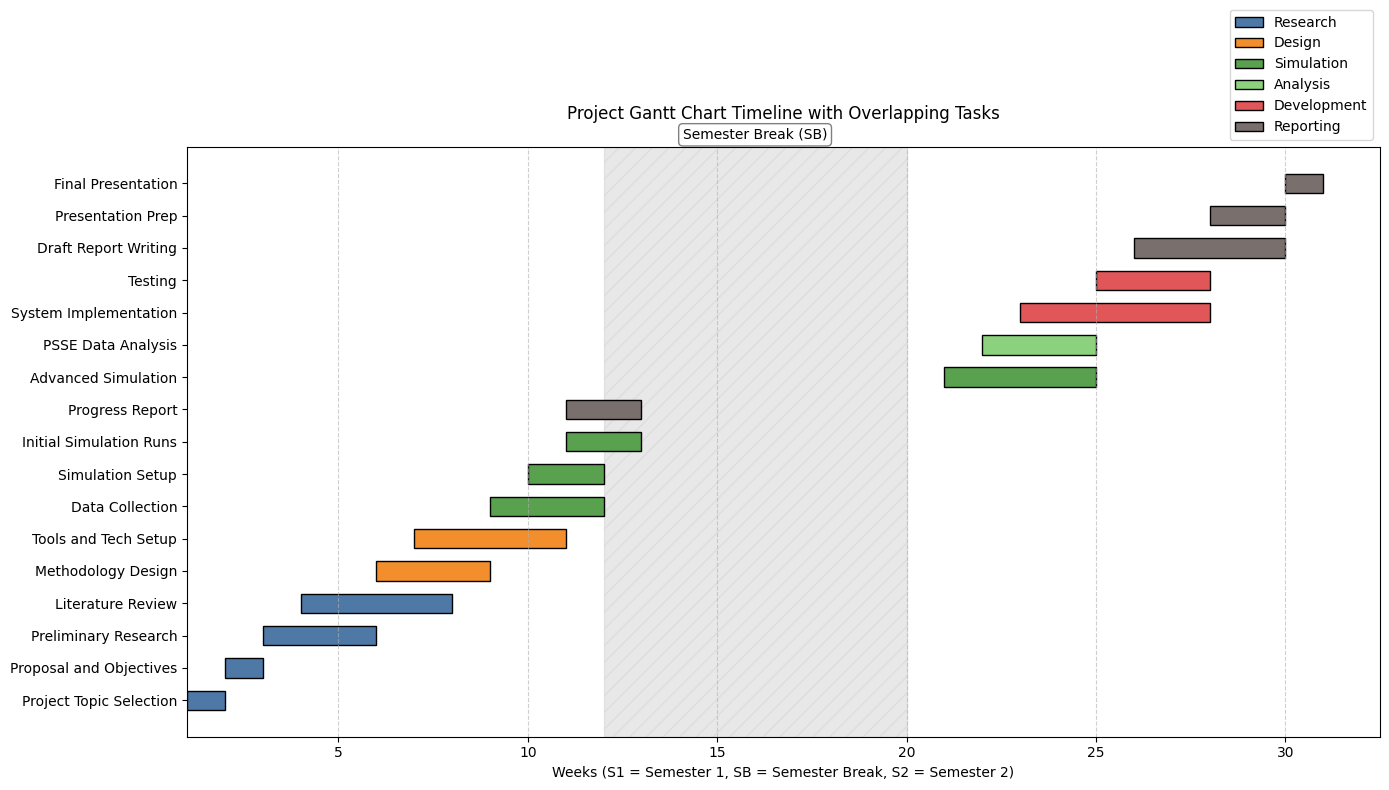

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.patches import Patch

# Define project tasks with their phases, start weeks, and durations
tasks = [
    {"name": "Project Topic Selection", "phase": "Research", "start": 1, "duration": 1},
    {"name": "Proposal and Objectives", "phase": "Research", "start": 2, "duration": 1},
    {"name": "Preliminary Research", "phase": "Research", "start": 3, "duration": 3},
    {"name": "Literature Review", "phase": "Research", "start": 4, "duration": 4, "overlap": 2},
    {"name": "Methodology Design", "phase": "Design", "start": 6, "duration": 3},
    {"name": "Tools and Tech Setup", "phase": "Design", "start": 7, "duration": 4},
    {"name": "Data Collection", "phase": "Simulation", "start": 9, "duration": 3},
    {"name": "Simulation Setup", "phase": "Simulation", "start": 10, "duration": 2},
    {"name": "Initial Simulation Runs", "phase": "Simulation", "start": 11, "duration": 2},
    {"name": "Progress Report", "phase": "Reporting", "start": 11, "duration": 2},
    # Semester Break (weeks 12-20)
    {"name": "Advanced Simulation", "phase": "Simulation", "start": 21, "duration": 4},
    {"name": "PSSE Data Analysis", "phase": "Analysis", "start": 22, "duration": 3},
    {"name": "System Implementation", "phase": "Development", "start": 23, "duration": 5},
    {"name": "Testing", "phase": "Development", "start": 25, "duration": 3},
    {"name": "Draft Report Writing", "phase": "Reporting", "start": 26, "duration": 4},
    {"name": "Presentation Prep", "phase": "Reporting", "start": 28, "duration": 2},
    {"name": "Final Presentation", "phase": "Reporting", "start": 30, "duration": 1},
]

# Define semester break (9 weeks)
semester_break = {"start": 12, "end": 20, "label": "Semester Break (SB)"}

# Define colors for each phase
phase_colors = {
    "Research": "#4E79A7",
    "Design": "#F28E2B",
    "Simulation": "#59A14F",
    "Analysis": "#8CD17D",
    "Development": "#E15759",
    "Reporting": "#79706E"
}

# Create figure
fig, ax = plt.subplots(figsize=(14, 8))

# Plot each task
for i, task in enumerate(tasks):
    ax.barh(
        y=task["name"],
        width=task["duration"],
        left=task["start"],
        color=phase_colors[task["phase"]],
        edgecolor='black',
        height=0.6
    )

# Add semester break
ax.axvspan(
    semester_break["start"],
    semester_break["end"],
    color='lightgray',
    alpha=0.5,
    hatch='//',
    zorder=0  # This will place it behind bars (default bar zorder is 1)
)
ax.text(
    x=np.mean([semester_break["start"], semester_break["end"]]),
    y=len(tasks)+0.5,
    s=semester_break["label"],
    ha='center',
    va='center',
    bbox=dict(facecolor='white', edgecolor='gray', boxstyle='round')
)

# Customize the plot
ax.set_xlabel('Weeks (S1 = Semester 1, SB = Semester Break, S2 = Semester 2)')
ax.set_title('Project Gantt Chart Timeline with Overlapping Tasks', pad=20)
ax.grid(axis='x', linestyle='--', alpha=0.6)

# Add phase legend
legend_elements = [Patch(facecolor=color, edgecolor='black', label=phase)
                  for phase, color in phase_colors.items()]
ax.legend(handles=legend_elements, loc='lower right', bbox_to_anchor=(1.0, 1.0))

# Adjust layout
plt.tight_layout()
plt.show()